Import package and path

In [8]:
import os
import json
import xarray as xr
import numpy as np
import matplotlib as plt
from datetime import datetime


from qcat.utility.file_structure import *
from qcat.utility.io_translator import *
# from analysis.analysis_method import *
from qcat.visualization.photon_dep_loss import * 

root_fd = r"D:\Data\resonator\Res_v2_abd_0920"
raw_data_fd = f"{root_fd}\\raw"
preprocess_data_fd = f"{root_fd}\\preprocess"
plot_data_fd = f"{root_fd}\\result"
output_fd = f"{root_fd}\\result"


Format convert ( LiteVNA )

In [9]:
from qcat.utility.file_structure import create_subfolder


# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

print(resonator_list)

for resonator_label in resonator_list:

    print(f"{resonator_label}")
    resonator_fd = f"{raw_data_fd}\\{resonator_label}"
    power_list = [d for d in os.listdir(resonator_fd) if os.path.isdir(os.path.join(resonator_fd, d))]

    create_subfolder(preprocess_data_fd,resonator_label)
    ave_resonator_folder = f"{preprocess_data_fd}\\{resonator_label}" 

    for power_label in power_list:

        # print(f"{resonator_label} {power_label}")

        power_fd = f"{resonator_fd}\\{power_label}"
        file_list = [d for d in os.listdir(power_fd) ]
        file_number = len(file_list)
        print( f"{file_number} files in {power_label}" )
        
        same_power_data = []
        
        for i, f_name in enumerate(file_list):

            # Read data
            # print(f"{i+1}/{file_number} {f_name}")
            file_fullpath = f"{power_fd}\\{f_name}"
            dataset = xr.open_dataset(file_fullpath)

            # Parse the time strings back to datetime objects
            start_time = datetime.strptime(dataset.attrs["start_time"], "%Y%m%d_%H%M%S")
            end_time = datetime.strptime(dataset.attrs["end_time"], "%Y%m%d_%H%M%S")
            if i==0: 
                start_time_all = start_time
                end_time_all = end_time
            if start_time < start_time_all : start_time_all = start_time
            if end_time > end_time_all : end_time_all = end_time_all


            power = dataset.attrs["power"]
            attenuation = dataset.attrs["attenuation"]
            # attenuation = 105

            frequency = dataset.coords["frequency"]
            same_power_data.append(dataset["s21"].values)

        # print(same_power_data)
        same_power_data = np.array(same_power_data)
        print(same_power_data.ndim)
        if same_power_data.ndim == 3:
            ave_data = np.mean( np.array(same_power_data), axis=0 )
        else:
            ave_data = same_power_data
        # print(ave_data)
        # Creating an xarray dataset
        output_data = {
            "s21": ( ["s_params","frequency"],
                    np.array([ave_data[0], ave_data[1]]) )
        }
        dataset = xr.Dataset(
            output_data,
            coords={ "s_params":np.array(["real","imag"]), "frequency": frequency })

        dataset.attrs["power"] = power
        dataset.attrs["attenuation"] = int(attenuation)
        dataset.attrs["start_time"] = str(start_time.strftime("%Y%m%d_%H%M%S"))
        dataset.attrs["end_time"] = str(end_time.strftime("%Y%m%d_%H%M%S"))
        # print(dataset)
        dataset.to_netcdf(f"{ave_resonator_folder}\\liteVNA_{str(attenuation)}_{str(power)}.nc")


['C49272', 'C50147', 'C51908', 'C52790', 'C53664', 'C54550', 'C55420', 'C56303', 'C57177']
C49272
3 files in att105_-30.0
3
3 files in att105_-35.0
3
3 files in att105_-40.0
3
3 files in att75_-10.0
3
3 files in att75_-15.0
3
3 files in att75_-20.0
3
3 files in att75_-25.0
3
3 files in att75_-30.0
3
3 files in att75_-35.0
3
3 files in att75_-40.0
3
3 files in att75_-45.0
3
3 files in att75_-5.0
3
3 files in att75_-50.0
3
3 files in att75_-55.0
3
3 files in att75_-60.0
3
3 files in att75_0.0
3
3 files in att75_10.0
3
3 files in att75_5.0
3
C50147
3 files in att105_-30.0
3
3 files in att105_-35.0
3
3 files in att105_-40.0
3
3 files in att75_-10.0
3
3 files in att75_-15.0
3
3 files in att75_-20.0
3
3 files in att75_-25.0
3
3 files in att75_-30.0
3
3 files in att75_-35.0
3
3 files in att75_-40.0
3
3 files in att75_-45.0
3
3 files in att75_-5.0
3
3 files in att75_-50.0
3
3 files in att75_-55.0
3
3 files in att75_-60.0
3
3 files in att75_0.0
3
3 files in att75_10.0
3
3 files in att75_5.0
3
C

Format convert ( QM )

In [3]:
from qcat.utility.file_structure import create_subfolder


raw_data_fd = r"d:\Data\resonator\5Q4C"
preprocess_data_fd = r"d:\Data\resonator\5Q4C\fit_data_pd\q4_min"
# Get all resonator from folder
# resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

f_name = "20240626_1504_power_dep_resonator_q4_ro_min.nc"
freq_ref = 5900 -166.6+10+1.36-1.11+1.49-3.38
ro_name = "q4_ro"

# Read data
# print(f"{i+1}/{file_number} {f_name}")
file_fullpath = f"{raw_data_fd}\\{f_name}"
dataset = xr.open_dataset(file_fullpath)
# dataset = dataset.transpose( "amp_ratio", "mixer", "frequency" )
print( dataset )
# Parse the time strings back to datetime objects
start_time = datetime.strptime(dataset.attrs["start_time"], "%Y%m%d_%H%M%S")
end_time = datetime.strptime(dataset.attrs["end_time"], "%Y%m%d_%H%M%S")
amp_ratio = dataset.coords["amp_ratio"].values
print(amp_ratio)
power_list = 0 +20*np.log10(amp_ratio)
attenuation = 0
print(power_list)
ave_data = dataset[ro_name].values

frequency = (dataset.coords["frequency"].values +freq_ref)*1e6
print( frequency )

temp_idx = ( 100, -100 )
for i, power_label in enumerate(power_list):

    print(power_label)
    # Creating an xarray dataset
    output_data = {
        "s21": ( ["s_params","frequency"],
                np.array([ave_data[0][i][temp_idx[0]:temp_idx[1]], ave_data[1][i][temp_idx[0]:temp_idx[1]]]) )
    }
    output_dataset = xr.Dataset(
        output_data,
        coords={ "s_params":np.array(["real","imag"]), "frequency": frequency[temp_idx[0]:temp_idx[1]] })

    output_dataset.attrs["power"] = power_label
    output_dataset.attrs["attenuation"] = int(attenuation)
    output_dataset.attrs["start_time"] = str(start_time.strftime("%m%d_%H%M%S"))
    output_dataset.attrs["end_time"] = str(end_time.strftime("%m%d_%H%M%S"))
    # print(dataset)
    output_dataset.to_netcdf(f"{preprocess_data_fd}\\QM_{str(attenuation)}_{power_label:.1f}.nc")



<xarray.Dataset> Size: 292kB
Dimensions:    (frequency: 500, amp_ratio: 36, mixer: 2)
Coordinates:
  * frequency  (frequency) float64 4kB -25.0 -24.9 -24.8 ... 24.7 24.8 24.9
  * amp_ratio  (amp_ratio) float64 288B 0.1 0.15 0.2 0.25 ... 1.7 1.75 1.8 1.85
  * mixer      (mixer) object 16B 'I' 'Q'
Data variables:
    q4_ro      (mixer, amp_ratio, frequency) float64 288kB ...
Attributes:
    start_time:  20240626_150352
    end_time:    20240626_150418
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45
 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85]
[-2.00000000e+01 -1.64781748e+01 -1.39794001e+01 -1.20411998e+01
 -1.04575749e+01 -9.11863911e+00 -7.95880017e+00 -6.93574972e+00
 -6.02059991e+00 -5.19274621e+00 -4.43697499e+00 -3.74173287e+00
 -3.09803920e+00 -2.49877473e+00 -1.93820026e+00 -1.41162149e+00
 -9.15149811e-01 -4.45527894e-01  3.85730987e-15  4.23785981e-01
  8.27853703e-01  1.21395681e+00  1.5

Format convert ( PYQUM )

In [4]:
from qcat.utility.file_structure import create_subfolder


raw_data_fd = r"D:\Data\resonator\ITRI_364_scalinQ\raw"
preprocess_data_fd = r"d:\Data\resonator\ITRI_364_scalinQ_new\fit_data_pd"
# Get all resonator from folder
resonator_list = [d for d in os.listdir(raw_data_fd) if os.path.isdir(os.path.join(raw_data_fd, d))]

print(resonator_list)

for resonator_label in resonator_list:

    print(f"{resonator_label}")
    resonator_fd = f"{raw_data_fd}\\{resonator_label}"
    power_list = [d for d in os.listdir(resonator_fd) if os.path.isdir(os.path.join(resonator_fd, d))]

    create_subfolder(preprocess_data_fd,resonator_label)
    ave_resonator_folder = f"{preprocess_data_fd}\\{resonator_label}" 

    mat_files = check_file_extension( resonator_fd, "mat")
    df_config = pd.read_json(f'{resonator_fd}\\config.json')
    for index, row in df_config.iterrows():
        attenuation = row["attenuation"]
        file_name = row["file_name"]
        print(f"{file_name} with {attenuation} dB attenuation")
        power_list, frequency, s21 = mat_to_numpy(f"{resonator_fd}\\{file_name}")
        print(frequency[0])
        zdata_2d = s21.transpose()
        for i, power_label in enumerate(power_list):
            # print(power_label)
            data = zdata_2d[i]


            # Creating an xarray dataset
            output_data = {
                "s21": ( ["s_params","frequency"],
                        np.array([data.real, data.imag]) )
            }
            dataset = xr.Dataset(
                output_data,
                coords={ "s_params":np.array(["real","imag"]), "frequency": frequency*1e9 })
            
            dataset.attrs["attenuation"] = int(attenuation)
            dataset.attrs["power"] = power_label
            dataset.to_netcdf(f"{ave_resonator_folder}\\PYQUM_{str(attenuation)}_{str(power_label)}.nc")


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'D:\\Data\\resonator\\ITRI_364_scalinQ\\raw'

Start Analysis

Processing C49272
D:\Data\resonator\Res_v2_abd_0920\preprocess\C49272
['liteVNA_105_-30.0.nc', 'liteVNA_105_-35.0.nc', 'liteVNA_105_-40.0.nc', 'liteVNA_75_-10.0.nc', 'liteVNA_75_-15.0.nc', 'liteVNA_75_-20.0.nc', 'liteVNA_75_-25.0.nc', 'liteVNA_75_-30.0.nc', 'liteVNA_75_-35.0.nc', 'liteVNA_75_-40.0.nc', 'liteVNA_75_-45.0.nc', 'liteVNA_75_-5.0.nc', 'liteVNA_75_-50.0.nc', 'liteVNA_75_-55.0.nc', 'liteVNA_75_-60.0.nc', 'liteVNA_75_0.0.nc', 'liteVNA_75_10.0.nc', 'liteVNA_75_5.0.nc']
C49272 start free analysis
0 th
1 th
2 th
3 th
4 th
5 th
6 th
7 th
8 th
9 th
10 th
11 th
12 th
13 th
14 th
15 th
16 th
17 th
Saving plot at D:\Data\resonator\Res_v2_abd_0920\result\C49272/C49272_free.png
delay: 6.846e-08,
amp_norm: 1.119e+00,
Qc: 7.424e+05,
alpha: -1.670e-01
Saving plot at D:\Data\resonator\Res_v2_abd_0920\result\C49272/C49272_refined.png
Processing C50147
D:\Data\resonator\Res_v2_abd_0920\preprocess\C50147
['liteVNA_105_-30.0.nc', 'liteVNA_105_-35.0.nc', 'liteVNA_105_-40.0.nc', 'liteVNA_75_-10.0

c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


9 th
10 th
11 th


c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:395: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diagonal(cov))
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:400: RuntimeWarning: invalid value encountered in sqrt
  Qi_no_corr_err = np.sqrt((dQl**2*cov[2][2]) + (dabsQc**2*cov[1][1])+(2*dQl*dabsQc*cov[2][1]))  #with correlations
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:408: RuntimeWarning: invalid value encountered in sqrt
  Qi_dia_corr_err =  np.sqrt(err1+2*err2)	 # including correlations


12 th
13 th
14 th
15 th
16 th
17 th
Saving plot at D:\Data\resonator\Res_v2_abd_0920\result\C50147/C50147_free.png
delay: 7.040e-08,
amp_norm: 4.230e-01,
Qc: 1.054e+12,
alpha: -2.436e+00
Saving plot at D:\Data\resonator\Res_v2_abd_0920\result\C50147/C50147_refined.png
Processing C51908
D:\Data\resonator\Res_v2_abd_0920\preprocess\C51908
['liteVNA_105_-30.0.nc', 'liteVNA_105_-35.0.nc', 'liteVNA_105_-40.0.nc', 'liteVNA_75_-10.0.nc', 'liteVNA_75_-15.0.nc', 'liteVNA_75_-20.0.nc', 'liteVNA_75_-25.0.nc', 'liteVNA_75_-30.0.nc', 'liteVNA_75_-35.0.nc', 'liteVNA_75_-40.0.nc', 'liteVNA_75_-45.0.nc', 'liteVNA_75_-5.0.nc', 'liteVNA_75_-50.0.nc', 'liteVNA_75_-55.0.nc', 'liteVNA_75_-60.0.nc', 'liteVNA_75_0.0.nc', 'liteVNA_75_10.0.nc', 'liteVNA_75_5.0.nc']
C51908 start free analysis
0 th
1 th
2 th
3 th


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circlefit.py:165: RuntimeWarning: invalid value encountered in sqrt
  r0 = 1./(2.*np.absolute(A_vec[0]))*np.sqrt(A_vec[1]*A_vec[1]+A_vec[2]*A_vec[2]-4.*A_vec[0]*A_vec[3])
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:374: RuntimeWarning: invalid value encountered in arcsin
  phi0 = -np.arcsin(yc/r0)
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:381: RuntimeWarning: invalid value encountered in cdouble_scalars
  Qc = 1./(1./complQc).real	# here, taking the real part of (1/complQc) from diameter correction method
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circlefit.py:365: Runtim

4 th
5 th
6 th
7 th
8 th
9 th


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10 th
11 th
12 th
13 th
14 th
15 th
16 th
17 th


c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:395: RuntimeWarning: invalid value encountered in sqrt
  errors = np.sqrt(np.diagonal(cov))
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:400: RuntimeWarning: invalid value encountered in sqrt
  Qi_no_corr_err = np.sqrt((dQl**2*cov[2][2]) + (dabsQc**2*cov[1][1])+(2*dQl*dabsQc*cov[2][1]))  #with correlations
c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:408: RuntimeWarning: invalid value encountered in sqrt
  Qi_dia_corr_err =  np.sqrt(err1+2*err2)	 # including correlations


Saving plot at D:\Data\resonator\Res_v2_abd_0920\result\C51908/C51908_free.png
delay: 6.786e-08,
amp_norm: 2.799e-02,
Qc: nan,
alpha: -2.654e-01


c:\users\shiau\pyqum\test\betasite\resonator_tools\resonator_tools\circuit.py:350: RuntimeWarning: invalid value encountered in divide
  return (z_data-A2*(f_data-frcal))/amp_norm*np.exp(1j*(-alpha+2.*np.pi*delay*f_data))


LinAlgError: SVD did not converge

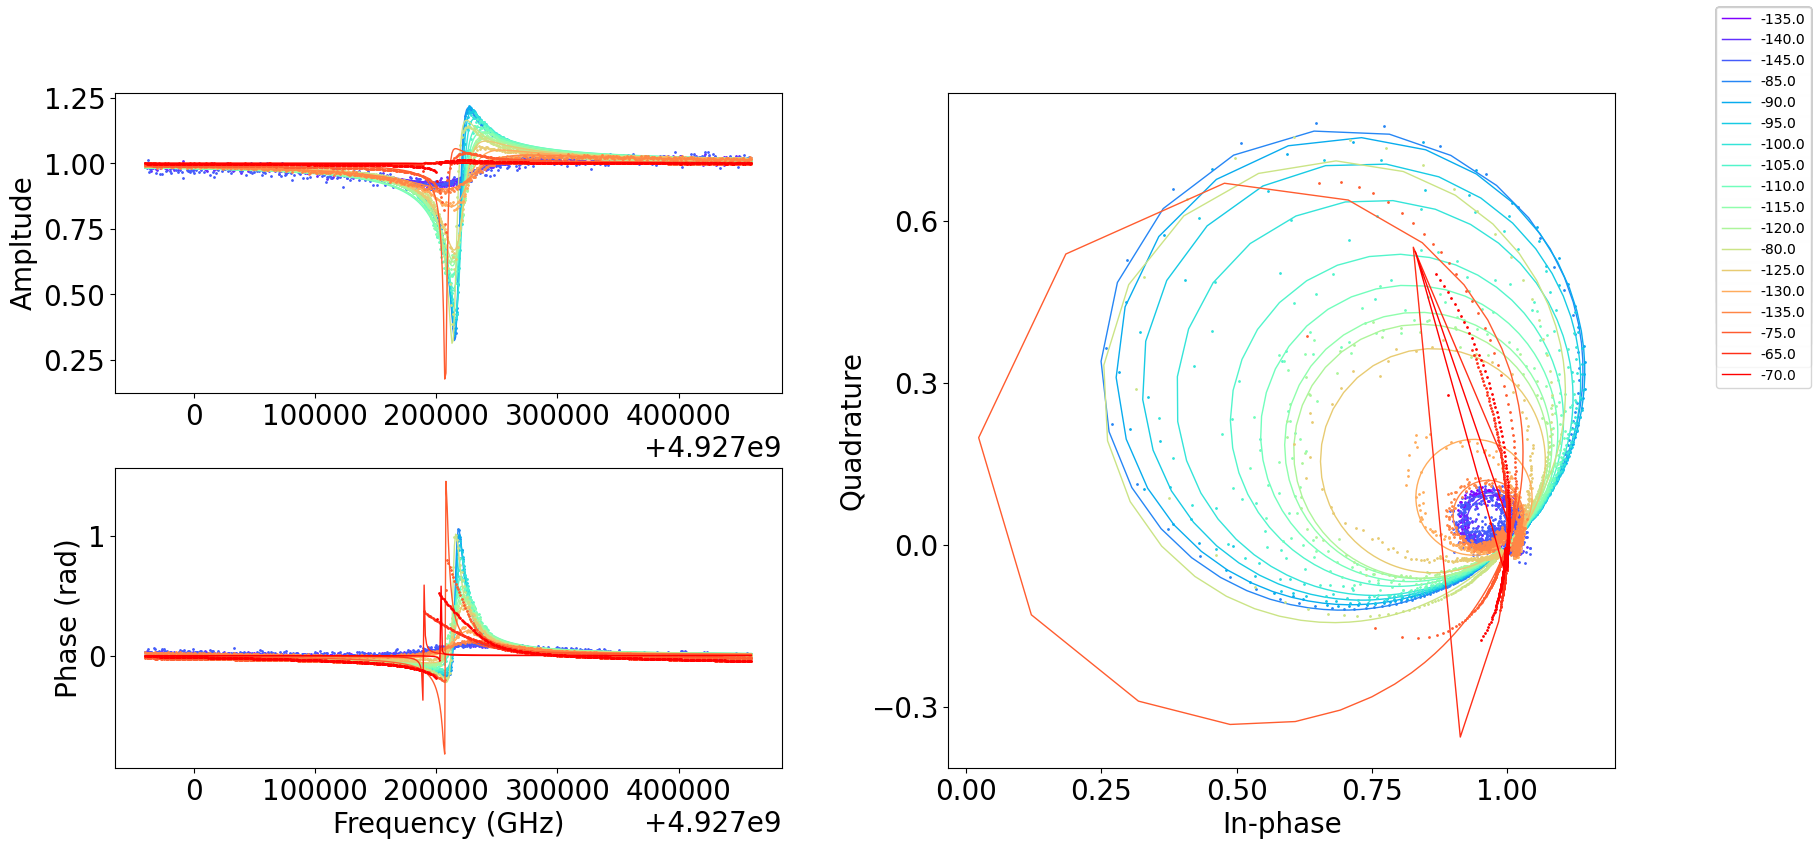

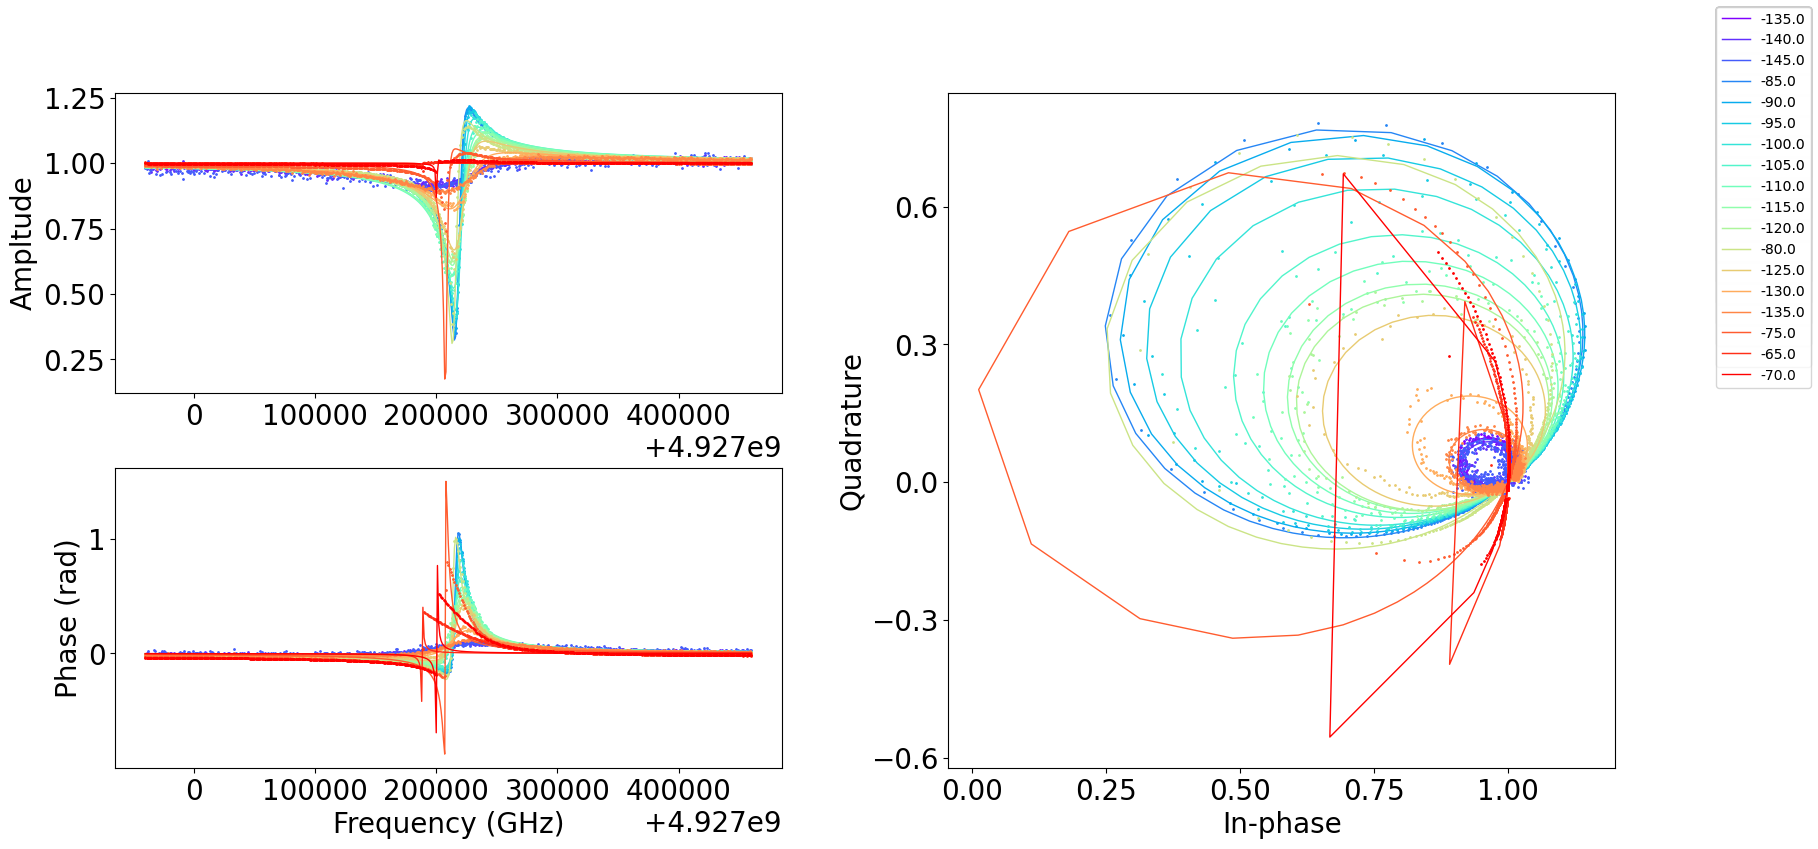

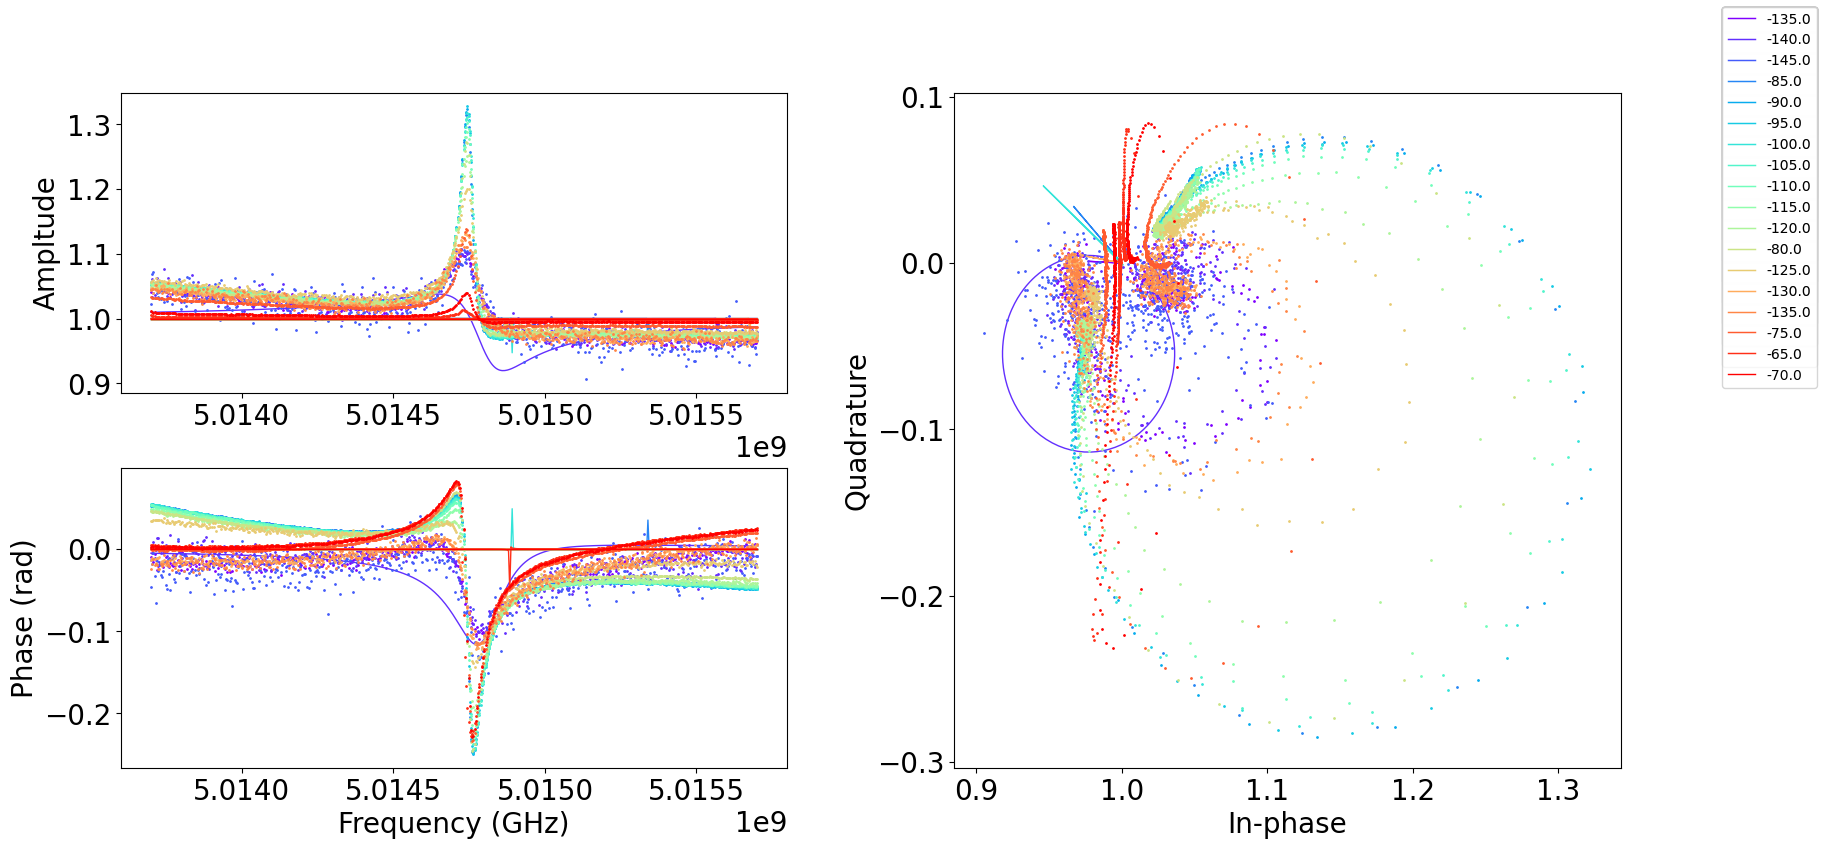

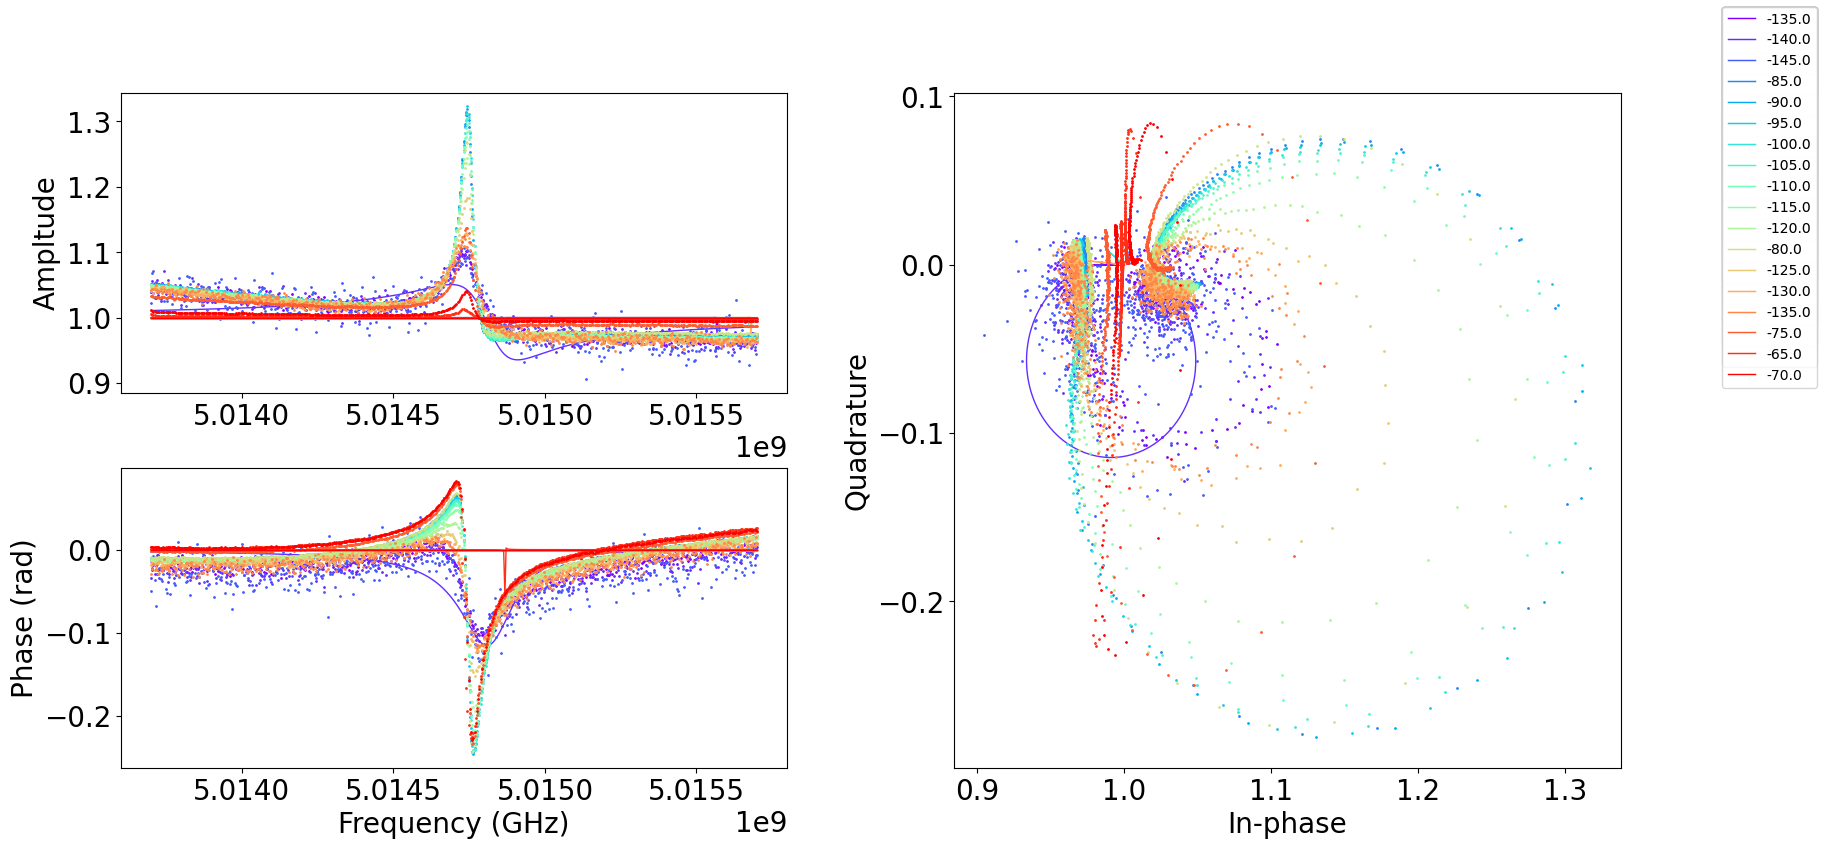

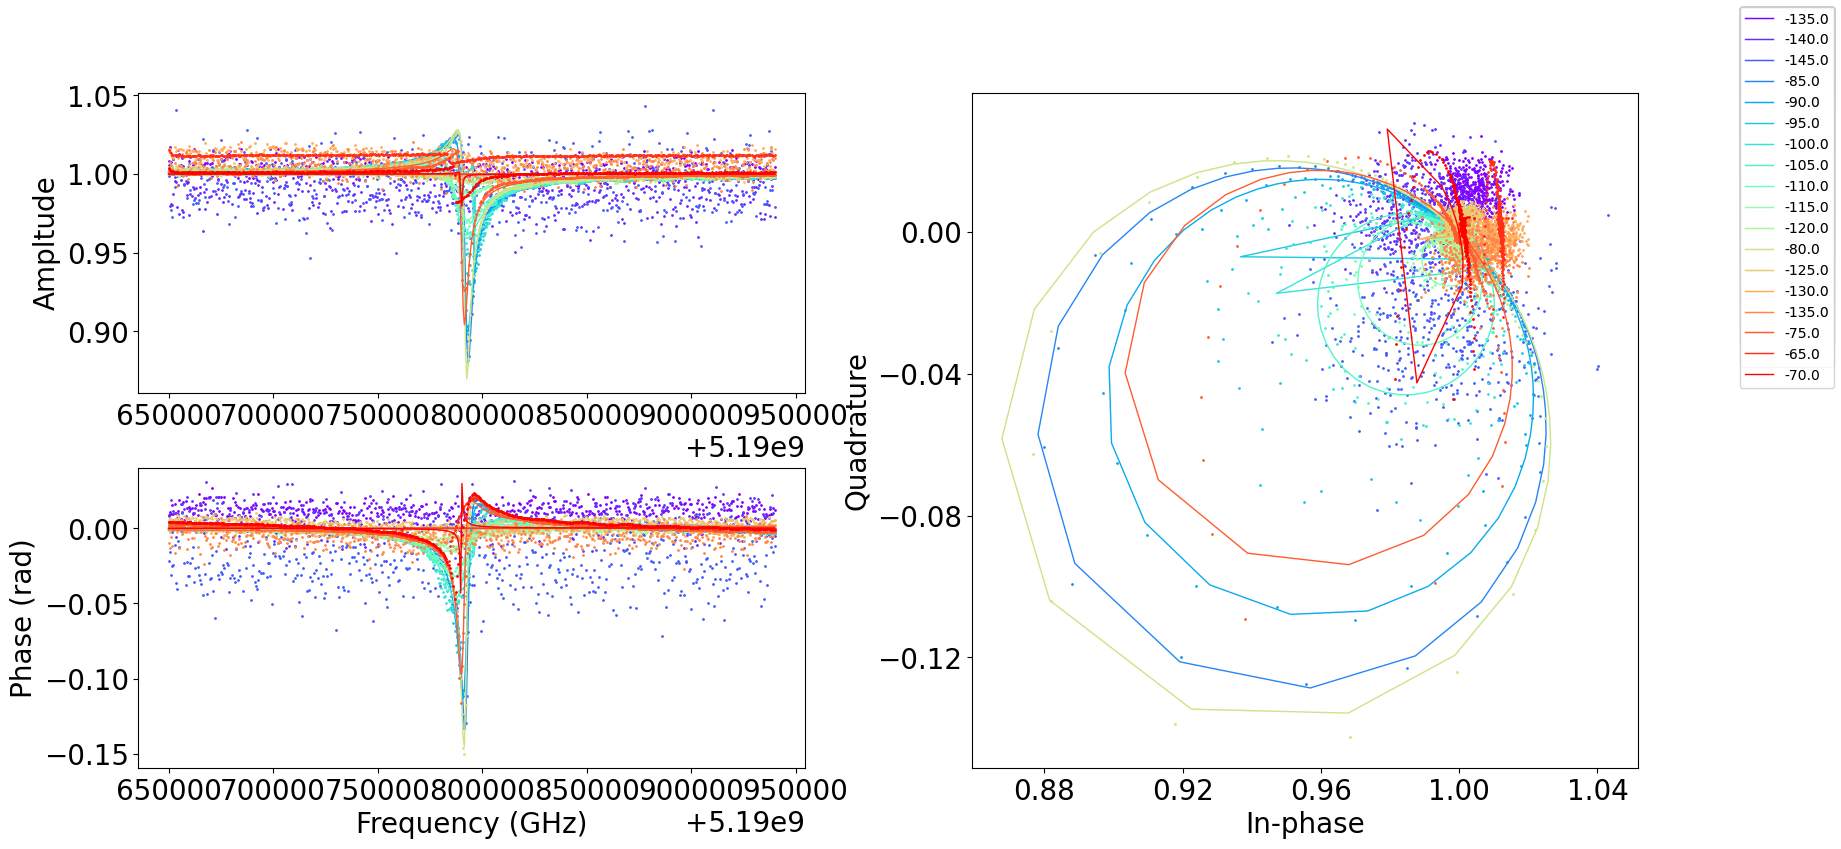

In [10]:
from qcat.analysis.resonator.photon_dep.res_data import *
from qcat.utility.file_structure import check_file_extension, create_subfolder


# Get all resonator from folder
resonator_list = [d for d in os.listdir(preprocess_data_fd) if os.path.isdir(os.path.join(preprocess_data_fd, d))]
# check_configure(f"{output_fd}", ["power_dep_fit"])
# resonator_list = ["C48398"]
all_resonator_result = []

for resonator_label in resonator_list:
    print(f"Processing {resonator_label}")

    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    resonator_data_folder = f"{preprocess_data_fd}\\{resonator_label}"
    resonator = PhotonDepResonator(resonator_label)
    # Find cavity data (nc file) in the folder
    file_list = check_file_extension( resonator_data_folder, "nc")
    print(resonator_data_folder)
    print(file_list)
    # file_list = ['liteVNA_80_-15.0.nc', 'liteVNA_80_-20.0.nc', 'liteVNA_80_-25.0.nc', 'liteVNA_80_-30.0.nc', 'liteVNA_80_-35.0.nc', 'liteVNA_80_-40.0.nc', 'liteVNA_80_-45.0.nc', 'liteVNA_80_-50.0.nc', 'liteVNA_80_-55.0.nc', 'liteVNA_80_-60.0.nc','liteVNA_110_-30.0.nc', 'liteVNA_110_-35.0.nc', 'liteVNA_110_-40.0.nc', 'liteVNA_110_-41.0.nc', 'liteVNA_110_-42.0.nc', 'liteVNA_110_-43.0.nc', 'liteVNA_110_-44.0.nc', 'liteVNA_110_-45.0.nc']

    for f_name in file_list:
        dataset = xr.open_dataset(f"{resonator_data_folder}\\{f_name}")
        power = dataset.attrs["power"]
        attenuation = dataset.attrs["attenuation"]
        frequency = dataset.coords["frequency"].values
        data = dataset["s21"].values
        resonator.import_array(frequency, data[0]+1j*data[1], power-attenuation)
    result = resonator.refined_analysis( result_folder )
    # result = resonator.free_analysis( result_folder )

    all_resonator_result.append( result )
    
    df_results = pd.concat(all_resonator_result)
    df_results.Name = resonator_label



Plot

In [6]:

all_resonator_result = []
folder_list = [d for d in os.listdir(preprocess_data_fd) if os.path.isdir(os.path.join(preprocess_data_fd, d))]

fr = []
qc = []
for resonator_label in folder_list:
    create_subfolder(output_fd,resonator_label)
    result_folder = f"{output_fd}\\{resonator_label}"

    # Plotting
    df_powerQ_free = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\free_result.csv" )
    plot_singleRes_powerQ_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_free(df_powerQ_free, cav_label=f"{resonator_label}", output_fd=result_folder)

    df_powerQ_refined = pd.read_csv( f"{plot_data_fd}\\{resonator_label}\\refined_result.csv" )
    plot_singleRes_powerQ_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    plot_singleRes_powerloss_refined(df_powerQ_refined, cav_label=f"{resonator_label}", output_fd=result_folder)
    fr.append(df_powerQ_refined["fr"].values[-1])
    qc.append(df_powerQ_refined["Qc_dia_corr_fixed"].values[-1])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120
ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120
ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120
ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120
ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120
ploting C40313
ploting C44659
ploting C48696
ploting C53128
ploting C56895
ploting C61120


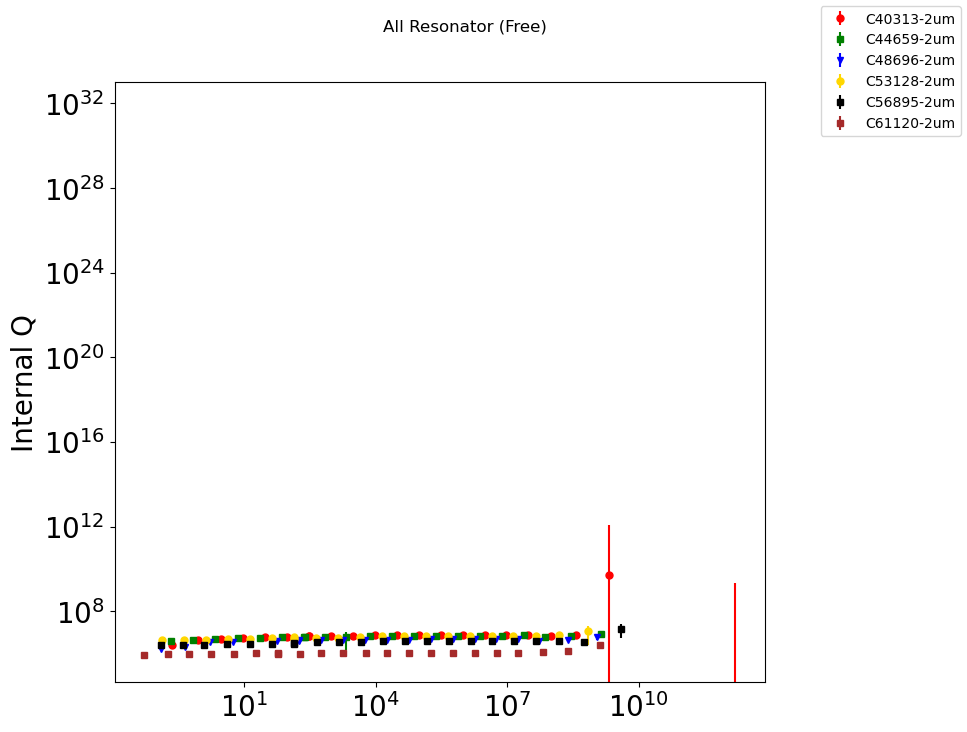

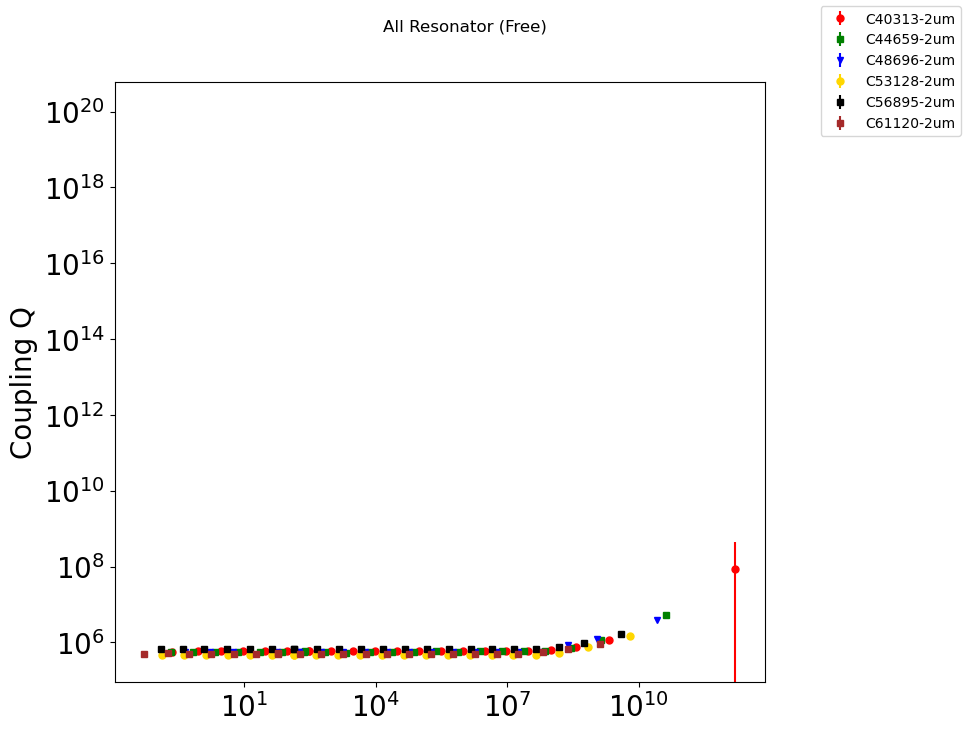

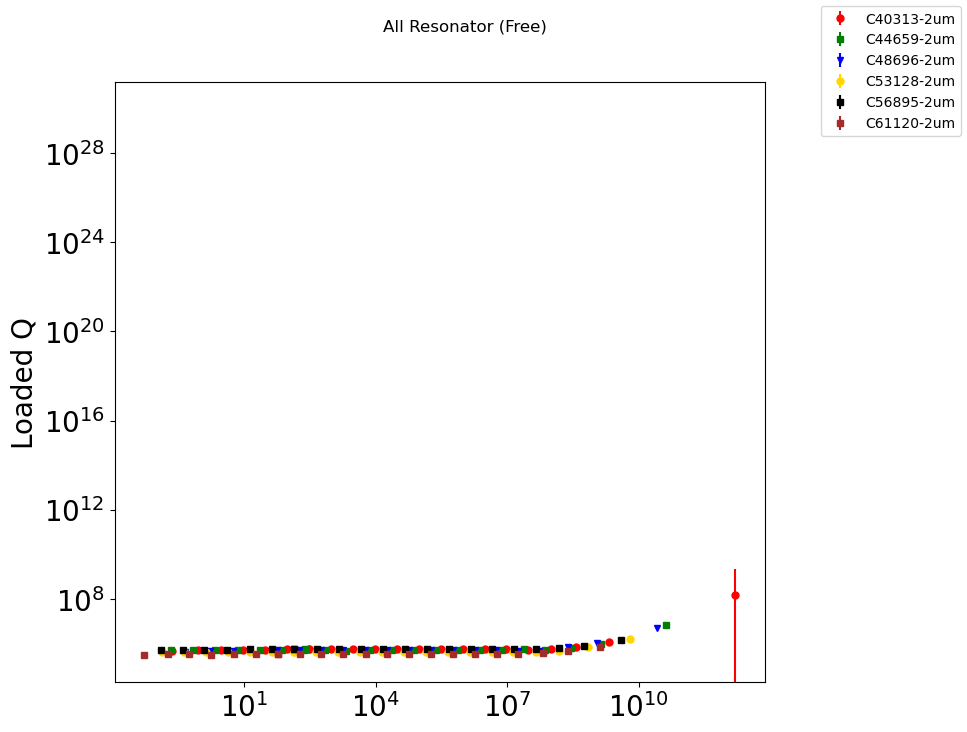

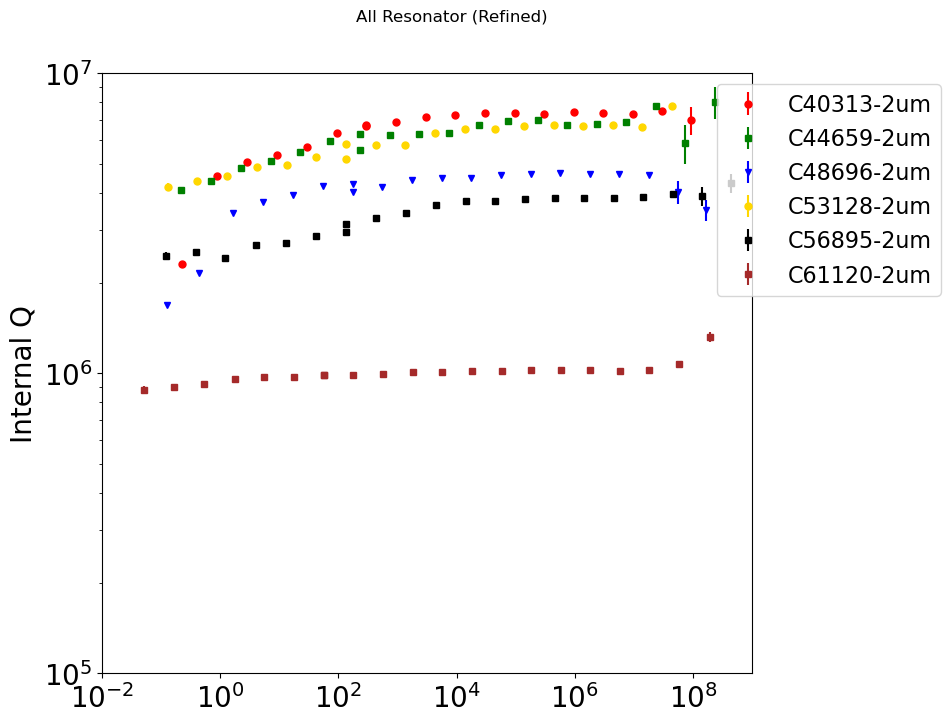

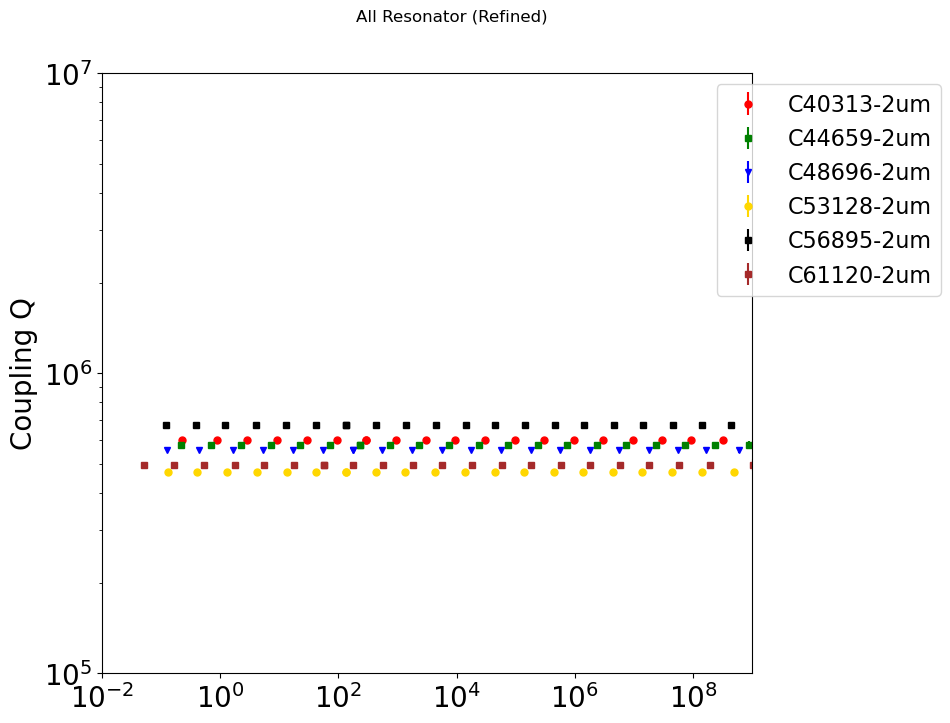

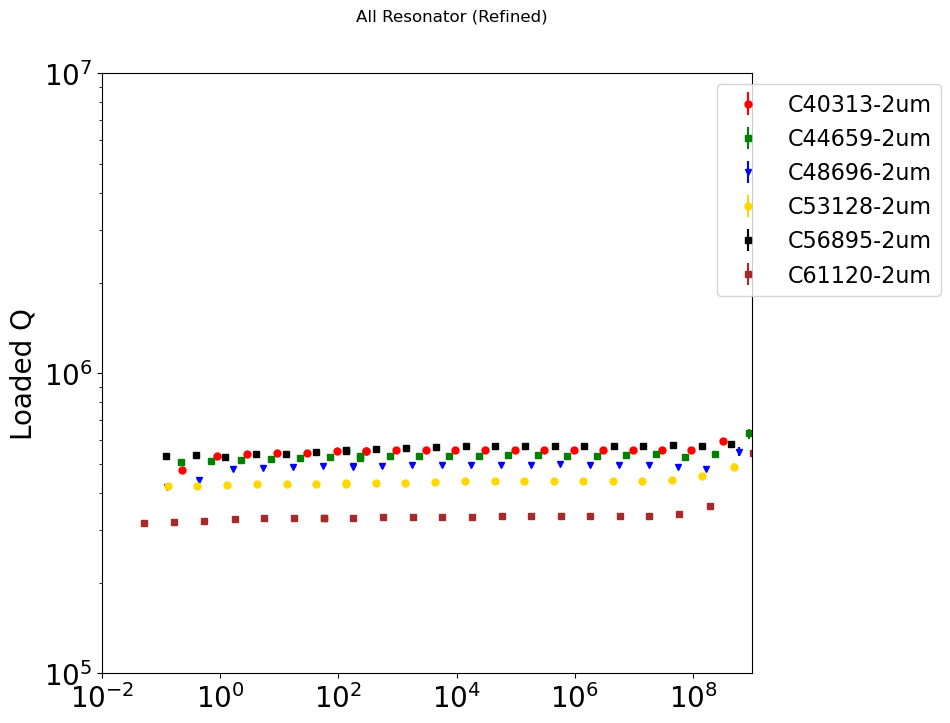

In [10]:
## After assignment each cavity, get foward analysis
assignment = pd.read_json(r"D:\Data\resonator\ITRI378_scalinQ_coil_0904_wWB\result\assignment.json")
plot_multiRes_powerQ_free( output_fd, assignment, output_fd)
plot_multiRes_powerQ_refined( output_fd, assignment, output_fd,((1e-2,1e9),(1e5,1e7)) )
# ((3e-1,3e5),(1e5,5e6))
pd.DataFrame({"fr":np.array(fr),"Qc":np.array(qc)}).to_csv( f"{output_fd}/Qc.csv" )

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 定義擬合的公式
def model_func(N_photons, delta_TLS, N_sat, alpha, delta_0):
    return delta_TLS / np.sqrt(1 + (N_photons / N_sat)**alpha) + delta_0

# 設定結果資料夾的路徑
result_folder = r"C:\Users\ASUS\Documents\python training\舊檔案\coil\result"  # 替換為你的result資料夾路徑

# 建立一個空的DataFrame來存儲所有擬合結果
fitting_results = pd.DataFrame(columns=['fr', 'delta_TLS', 'N_sat', 'alpha', 'delta_0'])

# 遍歷result資料夾內的所有子資料夾
for subdir, dirs, files in os.walk(result_folder):
    for file in files:
        if file == 'refined_result.csv':  # 檢查文件名稱
            file_path = os.path.join(subdir, file)
            
            # 讀取 CSV 文件
            df = pd.read_csv(file_path)
            
            # 提取數據
            Qi_dia_corr = df['Qi_dia_corr'].values
            photons = df['photons'].values
            Qi_dia_corr_err = df['Qi_dia_corr_err'].values  # 提取誤差數據

            # 根據 photons 排序
            sorted_indices = np.argsort(photons)
            photons_sorted = photons[sorted_indices]
            Qi_dia_corr_sorted = Qi_dia_corr[sorted_indices]
            Qi_dia_corr_err_sorted = Qi_dia_corr_err[sorted_indices]
            
            # 計算 delta_tot
            delta_tot = 1 / Qi_dia_corr_sorted

            # 設置初始猜測值
            delta_0_initial = np.min(delta_tot)
            delta_TLS_initial = np.max(delta_tot) - delta_0_initial
            alpha_initial = 1.0  # 在 0 到 2 之間選擇一個值
            N_sat_initial = 1e0  # 假設的初始值

            # 提取 fr 欄位的第一個值
            fr_value = df['fr'].iloc[0]

            # 擬合數據，加權擬合使用誤差的倒數平方
            weights = 1 / Qi_dia_corr_err_sorted**2
            try:
                popt, pcov = curve_fit(
                    model_func,
                    photons_sorted,
                    delta_tot,
                    p0=[delta_TLS_initial, N_sat_initial, alpha_initial, delta_0_initial],
                    sigma=Qi_dia_corr_err_sorted,
                    absolute_sigma=True
                )
                delta_TLS, N_sat, alpha, delta_0 = popt

                # 保存擬合結果
                new_row = pd.DataFrame({
                    'fr': [fr_value],
                    'delta_TLS': [delta_TLS],
                    'N_sat': [N_sat],
                    'alpha': [alpha],
                    'delta_0': [delta_0]
                })
                fitting_results = pd.concat([fitting_results, new_row], ignore_index=True)
                
                # 可選: 畫出每個擬合結果
                fitted_delta = model_func(photons_sorted, *popt)
                plt.scatter(photons_sorted, delta_tot, label='Data')
                plt.plot(photons_sorted, fitted_delta, color='red', label='Fit')
                plt.xscale('log')
                plt.yscale('log')
                plt.xlabel('N_{photons}')
                plt.ylabel('Δ_tot')
                plt.title(f'Fitting Result for fr={fr_value}')
                plt.legend()
                plt.show()

            except RuntimeError as e:
                print(f"Fitting failed for {file_path}: {e}")

# 將擬合結果保存到一個新的 CSV 文件
output_file = os.path.join(result_folder, 'fitting_results_new.csv')
fitting_results.to_csv(output_file, index=False)
print(f"所有擬合結果已保存至 {output_file}")
